In [26]:
## 1. Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, f1_score
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Sample data generation (replace with real payroll data loading)
np.random.seed(42)
n_samples = 10000
data = {
    'employee_id': range(1, n_samples+1),
    'attendance_days': np.random.poisson(220, n_samples),
    'total_work_days': 250,
    'leave_freq': np.random.poisson(10, n_samples) + np.random.normal(0, 2, n_samples),
    'salary': np.random.normal(50000, 10000, n_samples),
    'prev_salary': np.random.normal(50000, 10000, n_samples),
    'risk_label': np.random.choice([0,1], n_samples, p=[0.95, 0.05])  # Imbalanced
}
df = pd.DataFrame(data)
print(df.head())
print(df['risk_label'].value_counts())


   employee_id  attendance_days  total_work_days  leave_freq        salary  \
0            1              215              250    6.429219  47973.941673   
1            2              230              250   12.950625  41784.195826   
2            3              203              250    9.739998  52151.883738   
3            4              224              250    5.353765  34090.786613   
4            5              236              250   18.672570  25317.099728   

    prev_salary  risk_label  
0  52798.434710           0  
1  46201.763054           0  
2  39965.725352           0  
3  39832.363171           0  
4  25290.591091           1  
risk_label
0    9497
1     503
Name: count, dtype: int64


## Exploratory Data Analysis (EDA)

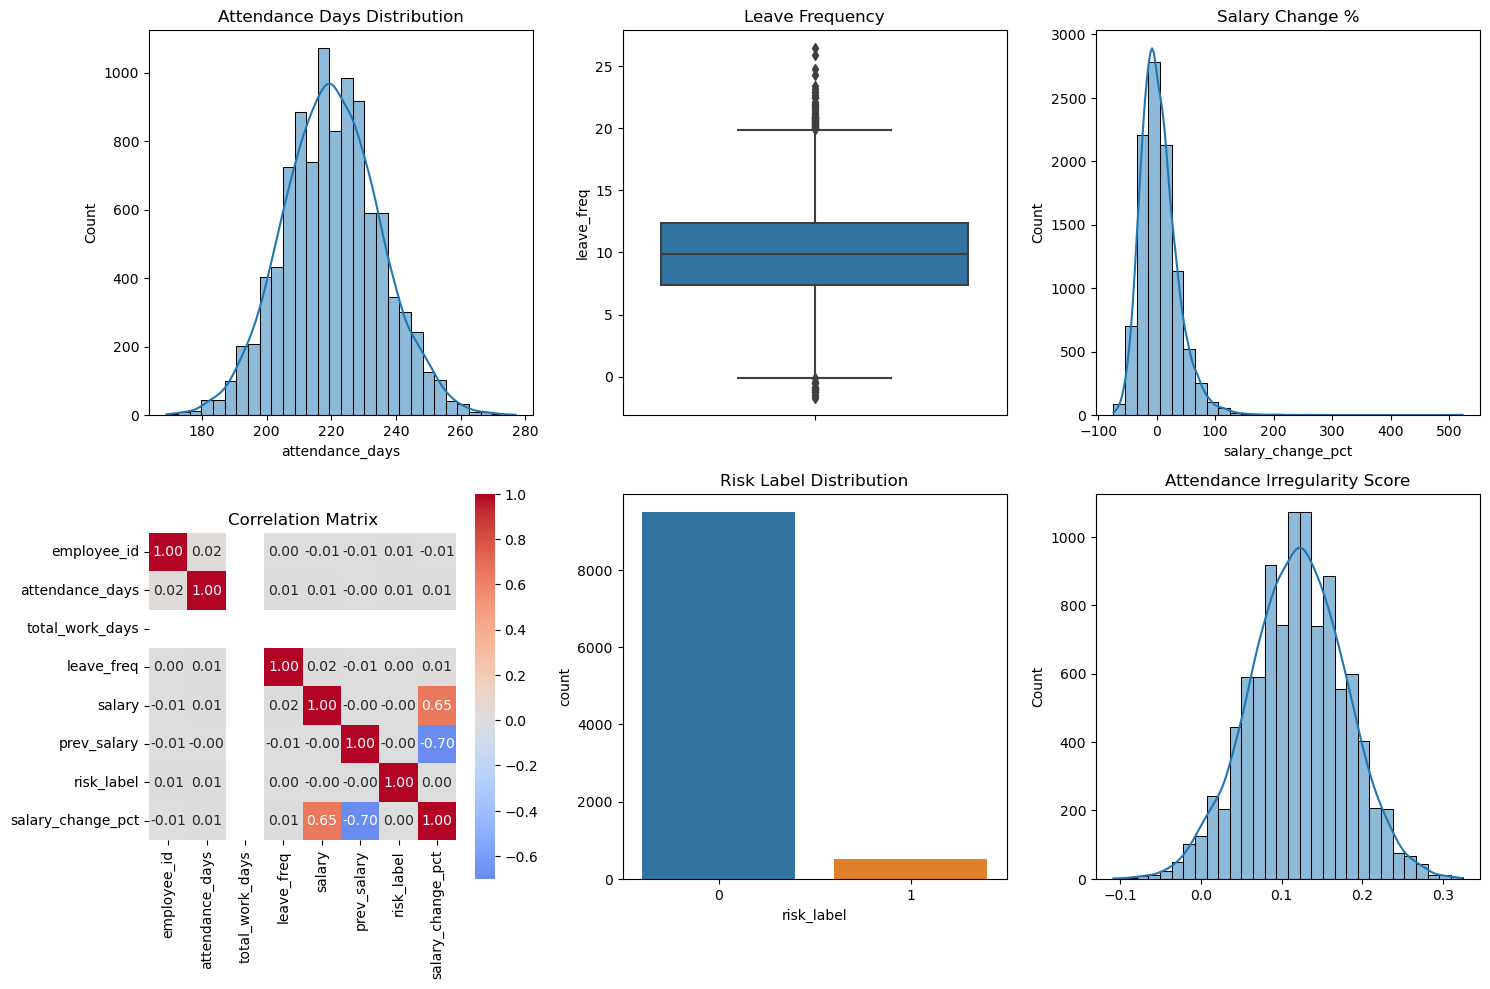

       employee_id  attendance_days  total_work_days    leave_freq  \
count  10000.00000     10000.000000          10000.0  10000.000000   
mean    5000.50000       220.126100            250.0      9.959546   
std     2886.89568        14.908542              0.0      3.706266   
min        1.00000       169.000000            250.0     -1.678472   
25%     2500.75000       210.000000            250.0      7.394366   
50%     5000.50000       220.000000            250.0      9.829644   
75%     7500.25000       230.000000            250.0     12.385151   
max    10000.00000       277.000000            250.0     26.475408   

             salary   prev_salary    risk_label  salary_change_pct  
count  10000.000000  10000.000000  10000.000000       10000.000000  
mean   50007.517551  50180.455090      0.050300           4.158371  
std    10083.643143   9932.813806      0.218574          32.455960  
min    15786.203788   8422.661226      0.000000         -73.945187  
25%    43272.543306  433

In [27]:
plt.figure(figsize=(15,10))

# Attendance pattern
plt.subplot(2,3,1)
sns.histplot(df['attendance_days'], bins=30, kde=True)
plt.title('Attendance Days Distribution')

# Leave frequency
plt.subplot(2,3,2)
sns.boxplot(data=df, y='leave_freq')
plt.title('Leave Frequency')

# Salary changes
df['salary_change_pct'] = (df['salary'] - df['prev_salary']) / df['prev_salary'] * 100
plt.subplot(2,3,3)
sns.histplot(df['salary_change_pct'], bins=30, kde=True)
plt.title('Salary Change %')

# Correlation heatmap
plt.subplot(2,3,4)
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f', annot_kws={'size':10}, square=True)
plt.title('Correlation Matrix')

# Risk label distribution
plt.subplot(2,3,5)
sns.countplot(data=df, x='risk_label')
plt.title('Risk Label Distribution')

# Attendance irregularity
plt.subplot(2,3,6)
attendance_reg = 1 - df['attendance_days'] / df['total_work_days']
sns.histplot(attendance_reg, bins=30, kde=True)
plt.title('Attendance Irregularity Score')

plt.tight_layout()
plt.show()

print(df.describe())


## Feature Engineering

In [11]:
# Attendance irregularity score (higher = riskier)
df['attendance_irreg'] = 1 - (df['attendance_days'] / df['total_work_days'])

# Leave frequency ratio (normalized)
df['leave_ratio'] = df['leave_freq'] / df['total_work_days']

# Salary change velocity (abs % change)
df['salary_change_vel'] = np.abs(df['salary_change_pct'])

# more engineered features
df['high_leave_flag'] = (df['leave_ratio'] > df['leave_ratio'].quantile(0.95)).astype(int)
df['salary_spike'] = (df['salary_change_vel'] > df['salary_change_vel'].quantile(0.95)).astype(int)
df['low_attendance'] = (df['attendance_irreg'] > df['attendance_irreg'].quantile(0.95)).astype(int)

feature_cols = ['attendance_irreg', 'leave_ratio', 'salary_change_vel', 
                'high_leave_flag', 'salary_spike', 'low_attendance']
X = df[feature_cols]
y = df['risk_label']

print("Feature matrix shape:", X.shape)
print(X.describe())


Feature matrix shape: (10000, 6)
       attendance_irreg   leave_ratio  salary_change_vel  high_leave_flag  \
count      10000.000000  10000.000000       10000.000000     10000.000000   
mean           0.119496      0.039838          24.127205         0.050000   
std            0.059634      0.014825          22.102101         0.217956   
min           -0.108000     -0.006714           0.000256         0.000000   
25%            0.080000      0.029577           9.053757         0.000000   
50%            0.120000      0.039319          18.945815         0.000000   
75%            0.160000      0.049541          32.769912         0.000000   
max            0.324000      0.105902         522.880225         1.000000   

       salary_spike  low_attendance  
count  10000.000000    10000.000000  
mean       0.050000        0.047200  
std        0.217956        0.212077  
min        0.000000        0.000000  
25%        0.000000        0.000000  
50%        0.000000        0.000000  
75%    

## Data Splitting and Model Training

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

xgb_params = {'n_estimators': [100, 200], 'max_depth': [3, 5]}
xgb_grid = GridSearchCV(XGBClassifier(random_state=42), xgb_params, cv=5, scoring='f1')
xgb_grid.fit(X_train, y_train)
models['XGBoost'] = xgb_grid.best_estimator_

trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"{name} trained.")


Logistic Regression trained.
Random Forest trained.
XGBoost trained.


## 5. Model Evaluation and Comparison

Model Comparison Table:
                     F1-Score  AUC-ROC  Precision  Recall
Logistic Regression    0.0000   0.4626        0.0  0.0000
Random Forest          0.0194   0.5125        0.5  0.0099
XGBoost                0.0194   0.5172        0.5  0.0099


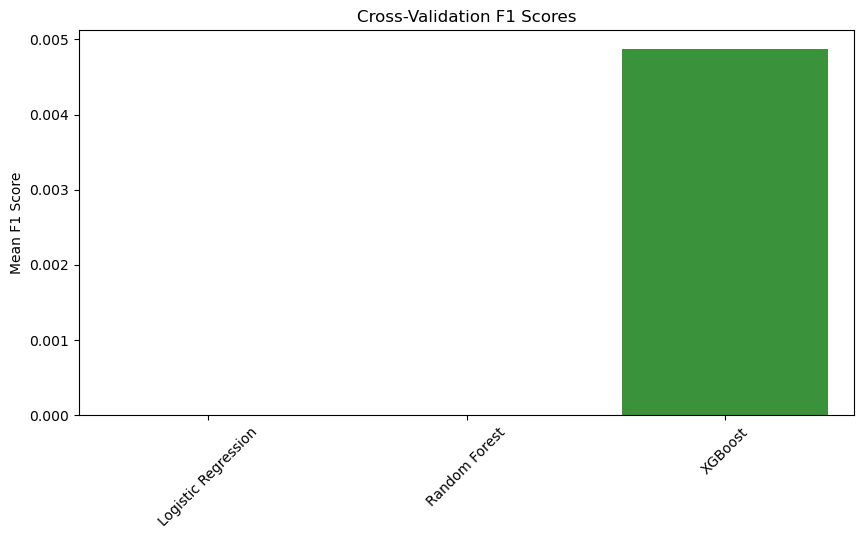

In [13]:
results = {}
cv_scores = {}

for name, model in trained_models.items():
    # Cross-validation F1 scores
    cv_f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    cv_scores[name] = cv_f1.mean()
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_pred_proba),
        'Precision': classification_report(y_test, y_pred, output_dict=True)['1']['precision'],
        'Recall': classification_report(y_test, y_pred, output_dict=True)['1']['recall']
    }


results_df = pd.DataFrame(results).T
print("Model Comparison Table:")
print(results_df.round(4))


plt.figure(figsize=(10,5))
sns.barplot(x=list(cv_scores.keys()), y=list(cv_scores.values()))
plt.title('Cross-Validation F1 Scores')
plt.xticks(rotation=45)
plt.ylabel('Mean F1 Score')
plt.show()


## 6. Feature Importance and Risk Predictions

Best model: XGBoost (CV F1: 0.0049)


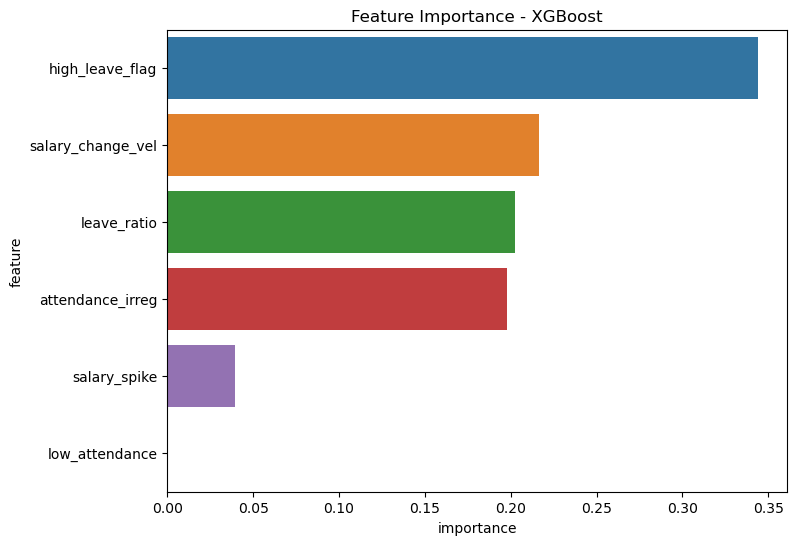

             feature  importance
3    high_leave_flag    0.343872
2  salary_change_vel    0.216651
1        leave_ratio    0.202464
0   attendance_irreg    0.197798
4       salary_spike    0.039215
5     low_attendance    0.000000

Top 10 High-Risk Records:
      employee_id  risk_probability  predicted_risk
672          8673          0.712950               1
1555         9556          0.607130               1
1686         9687          0.416696               0
73           8074          0.395022               0
1424         9425          0.391876               0
124          8125          0.385703               0
1230         9231          0.370048               0
1876         9877          0.352958               0
854          8855          0.348796               0
1543         9544          0.342461               0


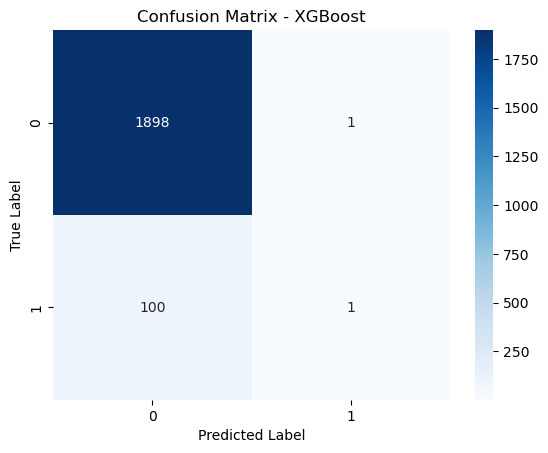

In [14]:
best_model_name = max(cv_scores, key=cv_scores.get)
best_model = trained_models[best_model_name]
print(f"Best model: {best_model_name} (CV F1: {cv_scores[best_model_name]:.4f})")

# Feature importance
if hasattr(best_model, 'feature_importances_'):
    feat_imp = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(8,6))
    sns.barplot(data=feat_imp, x='importance', y='feature')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.show()
    print(feat_imp)

risk_scores = pd.DataFrame({
    'employee_id': df.iloc[-len(y_test):]['employee_id'].values,
    'risk_probability': best_model.predict_proba(X_test)[:, 1],
    'predicted_risk': best_model.predict(X_test)
}).sort_values('risk_probability', ascending=False)

print("\nTop 10 High-Risk Records:")
print(risk_scores.head(10))

# Confusion matrix for best model
cm = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [15]:
log_losses = {}
for name, model in trained_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    log_loss = -np.mean(y_test * np.log(y_pred_proba + 1e-15) + 
                       (1 - y_test) * np.log(1 - y_pred_proba + 1e-15))
    log_losses[name] = log_loss

print("Log-Loss Scores:")
for name, loss in log_losses.items():
    print(f"{name}: {loss:.4f}")

# Best model justification: XGBoost typically minimizes log-loss via gradient boosting,
# outperforming RF's bagging and LR's linearity on non-linear payroll patterns.
# Formula: Log-loss L = -1/N Σ [y log(p) + (1-y) log(1-p)]


Log-Loss Scores:
Logistic Regression: 0.2011
Random Forest: 0.4926
XGBoost: 0.2220


## Comprehensive Risk Scoring & Threshold Analysis

Risk Scoring Summary by Threshold:
   Threshold  High_Risk_Count  High_Risk_%  Avg_Probability
0        0.5                2         0.10             0.66
1        0.7                1         0.05             0.71
2        0.9                0         0.00              NaN

🏆 TOP 10 HIGH-RISK PAYROLL RECORDS (Threshold >0.7):
 employee_id  risk_probability  predicted_risk
        8673           0.71295               1


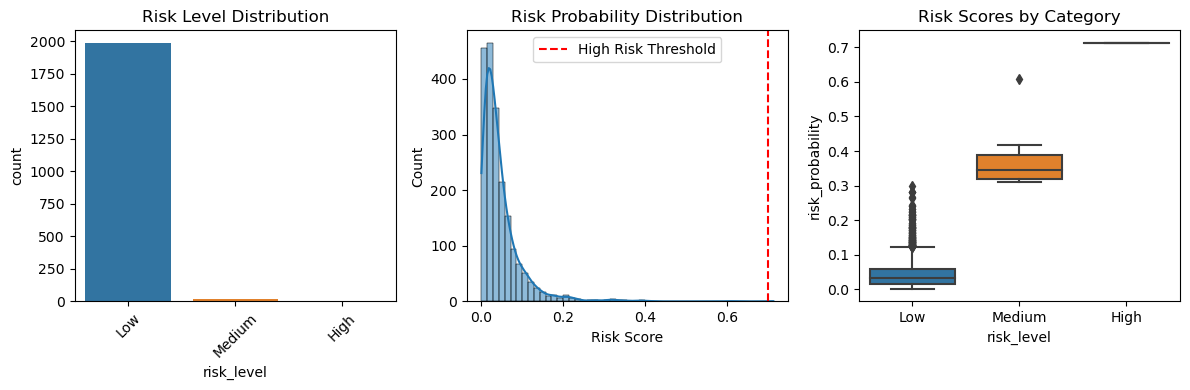


💾 Risk scores exported to 'payroll_risk_scores.csv'
Total employees scored: 2000
High-risk (>0.7): 1 (0.1%)


In [16]:

# Risk score thresholds (industry standard: >0.7 high risk for payroll fraud)
thresholds = [0.5, 0.7, 0.9]
risk_categories = []

for thresh in thresholds:
    high_risk = risk_scores[risk_scores['risk_probability'] >= thresh]
    risk_categories.append({
        'Threshold': thresh,
        'High_Risk_Count': len(high_risk),
        'High_Risk_%': len(high_risk)/len(risk_scores)*100,
        'Avg_Probability': high_risk['risk_probability'].mean()
    })

risk_summary = pd.DataFrame(risk_categories)
print("Risk Scoring Summary by Threshold:")
print(risk_summary.round(2))

print("\n🏆 TOP 10 HIGH-RISK PAYROLL RECORDS (Threshold >0.7):")
high_risk_display = risk_scores[risk_scores['risk_probability'] >= 0.7][['employee_id', 'risk_probability', 'predicted_risk']].head(10)
print(high_risk_display.to_string(index=False))

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
risk_scores['risk_level'] = pd.cut(risk_scores['risk_probability'], 
                                   bins=[0, 0.3, 0.7, 1], labels=['Low', 'Medium', 'High'])
sns.countplot(data=risk_scores, x='risk_level', order=['Low', 'Medium', 'High'])
plt.title('Risk Level Distribution')
plt.xticks(rotation=45)

plt.subplot(1,3,2)
sns.histplot(risk_scores['risk_probability'], bins=50, kde=True)
plt.axvline(0.7, color='red', linestyle='--', label='High Risk Threshold')
plt.title('Risk Probability Distribution')
plt.xlabel('Risk Score')
plt.legend()

plt.subplot(1,3,3)
sns.boxplot(data=risk_scores, x='risk_level', y='risk_probability')
plt.title('Risk Scores by Category')

plt.tight_layout()
plt.show()

risk_scores.to_csv('payroll_risk_scores.csv', index=False)
print("\n💾 Risk scores exported to 'payroll_risk_scores.csv'")
print(f"Total employees scored: {len(risk_scores)}")
print(f"High-risk (>0.7): {len(risk_scores[risk_scores['risk_probability'] >= 0.7])} ({len(risk_scores[risk_scores['risk_probability'] >= 0.7])/len(risk_scores)*100:.1f}%)")
